In [14]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set(style='whitegrid')
plt.rcParams['figure.dpi'] = 120


In [15]:

# Adjust filenames to match your local cleaned CSV names/paths
benin = pd.read_csv('../data/benin-malanville_clean.csv', parse_dates=['Timestamp'], infer_datetime_format=True)
sierra = pd.read_csv('../data/sierraleone-bumbuna_clean.csv', parse_dates=['Timestamp'], infer_datetime_format=True)
togo = pd.read_csv('../data/togo-dapaong_qc_clean.csv', parse_dates=['Timestamp'], infer_datetime_format=True)

# Tag country

benin['Country'] = 'Benin'
sierra['Country'] = 'Sierra Leone'
togo['Country'] = 'Togo'

# Combine into single DataFrame for easy plotting
df = pd.concat([benin, sierra, togo], ignore_index=True)

# Quick info
print("Shapes:", { 'Benin': benin.shape, 'Sierra Leone': sierra.shape, 'Togo': togo.shape })
df.head()


Shapes: {'Benin': (517860, 20), 'Sierra Leone': (509308, 20), 'Togo': (516349, 20)}


,Timestamp,GHI,DNI,DHI,ModA,ModB,Tamb,RH,WS,WSgust,WSstdev,WD,WDstdev,BP,Cleaning,Precipitation,TModA,TModB,Comments,Country
0,2021-08-09 00:01:00,-1.2,-0.2,-1.1,0.0,0.0,26.2,93.4,0.0,0.4,0.1,122.1,0.0,998,0,0.0,26.3,26.2,NaN,Benin
1,2021-08-09 00:02:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.6,0.0,0.0,0.0,0.0,0.0,998,0,0.0,26.3,26.2,NaN,Benin
2,2021-08-09 00:03:00,-1.1,-0.2,-1.1,0.0,0.0,26.2,93.7,0.3,1.1,0.5,124.6,1.5,997,0,0.0,26.4,26.2,NaN,Benin
3,2021-08-09 00:04:00,-1.1,-0.1,-1.0,0.0,0.0,26.2,93.3,0.2,0.7,0.4,120.3,1.3,997,0,0.0,26.4,26.3,NaN,Benin
4,2021-08-09 00:05:00,-1.0,-0.1,-1.0,0.0,0.0,26.2,93.3,0.1,0.7,0.3,113.2,1.0,997,0,0.0,26.4,26.3,NaN,Benin


In [16]:

# standardize column names and basic cleaning
df.columns = [c.strip() for c in df.columns]

# Ensure key columns exist
for col in ['GHI','DNI','DHI']:
    if col not in df.columns:
        df[col] = np.nan

# Remove impossible negative irradiance readings (set to NaN)
for col in ['GHI','DNI','DHI']:
    df.loc[df[col] < 0, col] = np.nan

# Optional: show percent missing per column
missing = (df.isna().sum() / len(df) * 100).round(2).sort_values(ascending=False)
print("Missing % per column:\n", missing.head(10))


Missing % per column:
 Comments     100.00
GHI           50.03
DNI           34.88
DHI           33.60
Timestamp      0.00
ModA           0.00
Tamb           0.00
ModB           0.00
WS             0.00
WSgust         0.00
dtype: float64


In [17]:

summary = df.groupby('Country')[['GHI','DNI','DHI']].agg(['mean','median','std']).round(2)
# tidy columns for saving/printing
summary.columns = ['_'.join(col).strip() for col in summary.columns.values]
summary = summary.reset_index().set_index('Country')
summary
# save summary to reports
import os
os.makedirs('reports', exist_ok=True)
summary.to_csv('reports/compare_summary_table.csv')
print("Saved summary to reports/compare_summary_table.csv")


Saved summary to reports/compare_summary_table.csv


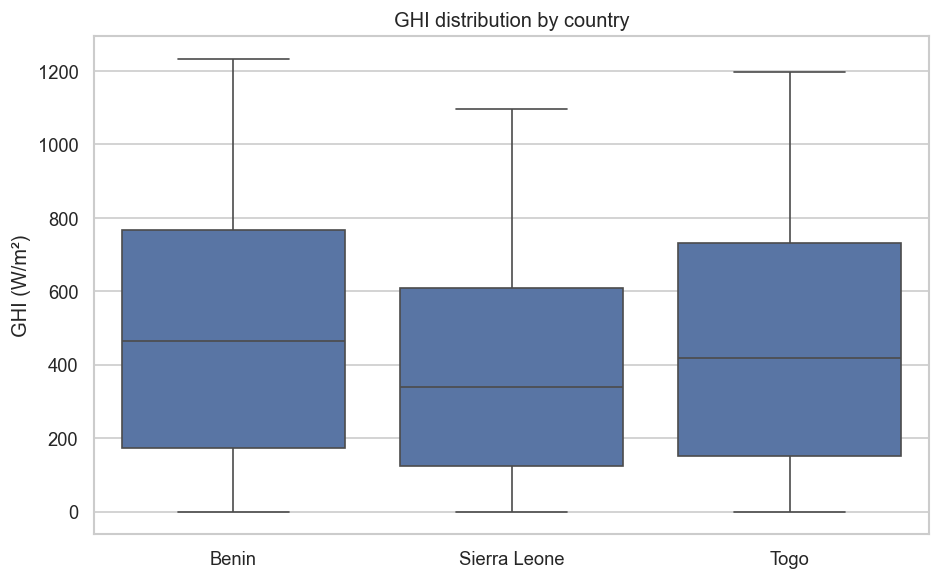

Saved: dashboard_screenshots/boxplot_ghi.png


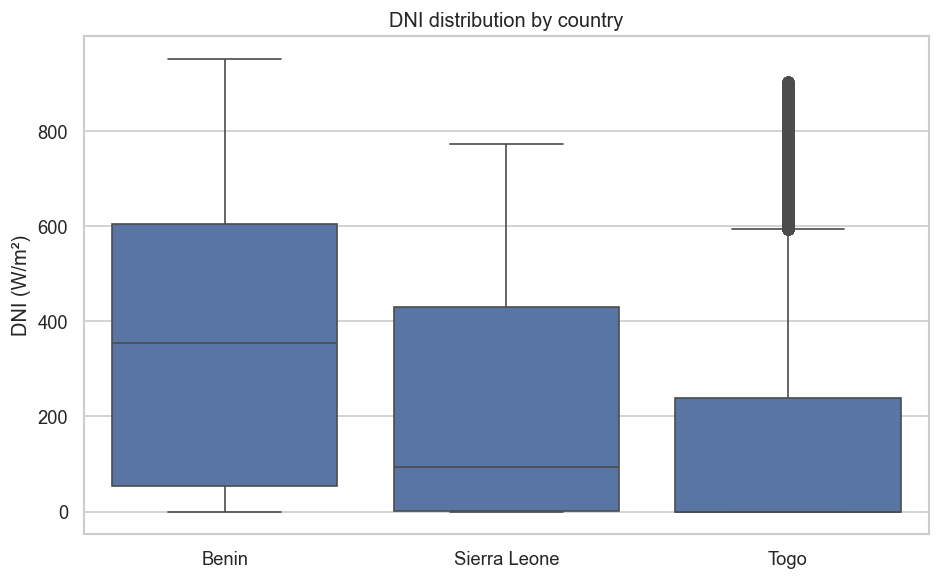

Saved: dashboard_screenshots/boxplot_dni.png


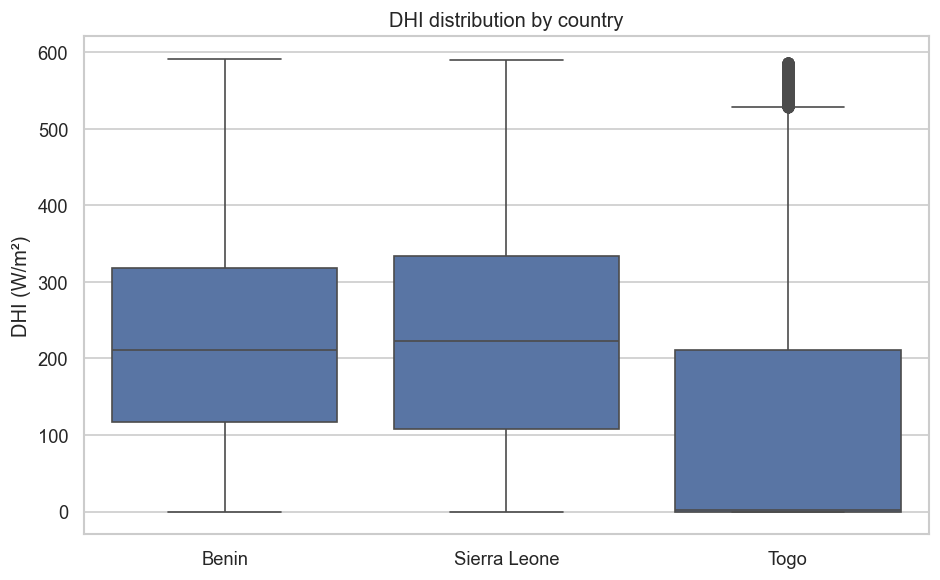

Saved: dashboard_screenshots/boxplot_dhi.png


In [18]:

metrics = ['GHI','DNI','DHI']
os.makedirs('dashboard_screenshots', exist_ok=True)

for metric in metrics:
    plt.figure(figsize=(8,5))
    sns.boxplot(data=df, x='Country', y=metric)
    plt.title(f'{metric} distribution by country')
    plt.ylabel(metric + ' (W/m²)')
    plt.xlabel('')
    plt.tight_layout()
    out = f'dashboard_screenshots/boxplot_{metric.lower()}.png'
    plt.savefig(out, dpi=150)
    plt.show()
    print("Saved:", out)


In [19]:

# extract groups (dropna)
ghi_b = df.loc[df['Country']=='Benin','GHI'].dropna()
ghi_s = df.loc[df['Country']=='Sierra Leone','GHI'].dropna()
ghi_t = df.loc[df['Country']=='Togo','GHI'].dropna()

print("Sample sizes (GHI):", len(ghi_b), len(ghi_s), len(ghi_t))

# ANOVA (parametric)
try:
    f_stat, p_val = stats.f_oneway(ghi_b, ghi_s, ghi_t)
    print("ANOVA: F =", round(f_stat,4), " p =", p_val)
except Exception as e:
    print("ANOVA failed:", e)
    f_stat, p_val = (np.nan, np.nan)

# Kruskal-Wallis (non-parametric)
try:
    h_stat, p_kw = stats.kruskal(ghi_b, ghi_s, ghi_t)
    print("Kruskal-Wallis: H =", round(h_stat,4), " p =", p_kw)
except Exception as e:
    print("Kruskal-Wallis failed:", e)
    h_stat, p_kw = (np.nan, np.nan)

# Save results
with open('reports/stat_tests.txt','w') as f:
    f.write(f"ANOVA: F={f_stat}, p={p_val}\nKruskal-Wallis: H={h_stat}, p={p_kw}\n")
print("Saved stat tests to reports/stat_tests.txt")


Sample sizes (GHI): 260897 249927 260477
ANOVA: F = 5694.6428  p = 0.0
Kruskal-Wallis: H = 10202.039  p = 0.0
Saved stat tests to reports/stat_tests.txt


Country
Benin           471.71
Togo            446.10
Sierra Leone    382.12
Name: GHI, dtype: float64


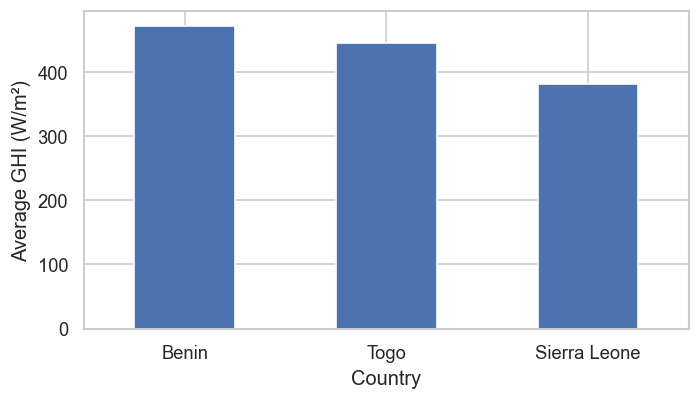

Saved: dashboard_screenshots/avg_ghi_ranking.png


In [20]:

avg_ghi = df.groupby('Country')['GHI'].mean().sort_values(ascending=False).round(2)
print(avg_ghi)

# Plot (plotly interactive)
fig = px.bar(x=avg_ghi.index, y=avg_ghi.values, labels={'x':'Country','y':'Average GHI'}, title='Average GHI by Country', text=avg_ghi.values)
fig.show()

# Save static copy
plt.figure(figsize=(6,3.5))
avg_ghi.plot(kind='bar', rot=0)
plt.ylabel('Average GHI (W/m²)')
plt.tight_layout()
plt.savefig('dashboard_screenshots/avg_ghi_ranking.png', dpi=150)
plt.show()
print("Saved: dashboard_screenshots/avg_ghi_ranking.png")


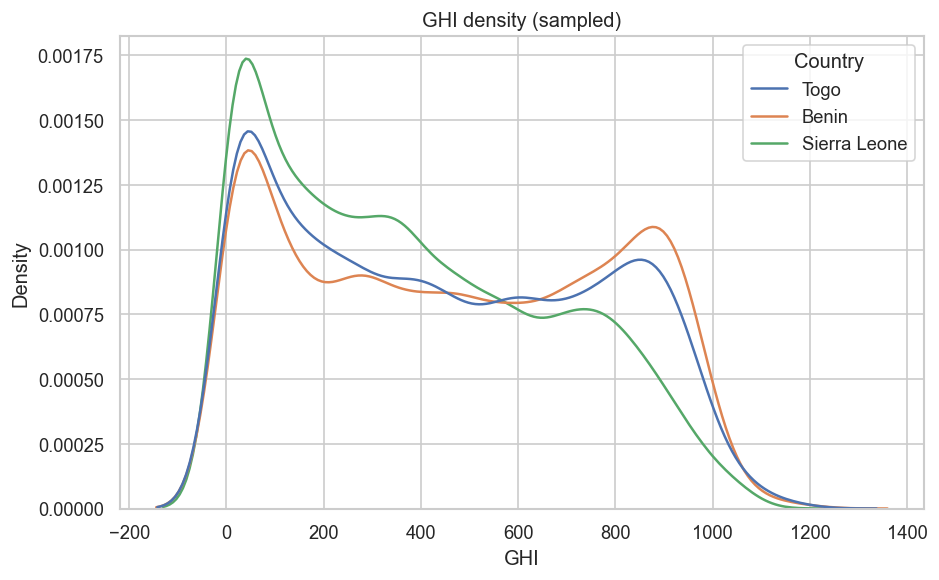

In [21]:

# If your datasets are very large, sample for scatter/density plots
sample = df.dropna(subset=['GHI']).sample(frac=0.05, random_state=42)  # 5% sample
plt.figure(figsize=(8,5))
sns.kdeplot(data=sample, x='GHI', hue='Country', common_norm=False)
plt.title('GHI density (sampled)')
plt.tight_layout()
plt.show()
